# 回帰NNの結果を可視化する

- caffe-1d-regression.cppの結果を可視化する
- １次元の線形回帰ネットワークの入力と出力を可視化

In [1]:
import os, sys
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
#input_data = pd.read_csv('../data/sampledata_1d_linear_short.csv')
input_data = pd.read_csv('../data/sampledata_discrete_target.csv')
predicted_result = pd.read_csv('../data/predicted_result.csv', names=['x', 'y'])

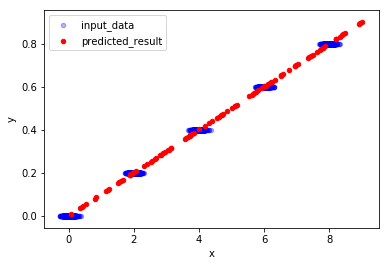

In [3]:
fig, ax = plt.subplots(1, 1)
input_data.plot.scatter(x='x', y='y', ax=ax, label='input_data', color='blue', alpha=0.3)
predicted_result.plot.scatter(x='x', y='y', ax=ax, label='predicted_result', color='red')


# ネットワークパラメータを出力
- 学習済みモデルを取り込んで、結果を眺める
- caffeで学習した結果は、[_iter_4000.caffemodel]みたいな名前で出力されている
    - 4000はsolverの設定ファイルに記載してあるmax_iter
- caffemodelを取り込んで、中身を見るので、pycaffeをimportする
    - chainerとかでもいける

In [4]:
import caffe

In [5]:
# caffemodelの指定
model_file = '../_iter_4000.caffemodel'
if os.path.isfile(model_file):
    print 'model file found. : {}'.format(model_file)
else:
    print 'nodel_file not found'

caffe.set_mode_cpu()

# 学習済みmodelのロードする
model_def = '../net.prototxt'
net = caffe.Net(model_def,      # defines the structure of the model
                model_file,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

model file found. : ../_iter_4000.caffemodel


In [6]:
# blob
net.blobs

OrderedDict([('input', <caffe._caffe.Blob at 0x7f2b59bffc08>),
             ('dummy_label1', <caffe._caffe.Blob at 0x7f2b59bffde8>),
             ('ip', <caffe._caffe.Blob at 0x7f2b59bffc80>),
             ('target', <caffe._caffe.Blob at 0x7f2b59bffed8>),
             ('dummy_label2', <caffe._caffe.Blob at 0x7f2b59bffaa0>),
             ('loss', <caffe._caffe.Blob at 0x7f2b59bfff50>)])

## 重みを確認
- １次元の回帰なので、y=ax+bのaとb

In [7]:
net_param = net.params['ip']
weight = net_param[0].data
bias = net_param[1].data
print 'weight : {}'.format(weight) # [入力次元, 出力次元]のnxm次元配列になる
print 'bias : {}'.format(bias)

weight : [[ 0.09988841]]
bias : [ 0.00036424]


## 推論ステップ
- pycaffeで推論をさせたい
- 失敗
    - [ここ](https://github.com/BVLC/caffe/issues/5493)を見ると、pythonからMemoryDataLayerを使う場合に発生する問題らしい
    - [ここ](https://github.com/BVLC/caffe/issues/5528)も参照

In [8]:
print type(net.blobs['input'].data)
print net.blobs['input'].data.shape

<type 'numpy.ndarray'>
(10, 1, 1, 1)


入力方法を変えてみたり、したがforward関数を実行するとクラッシュする。

In [9]:
tmp_data = np.arange(0, 10, 1, dtype='float32')
tmp_data = tmp_data[:, np.newaxis, np.newaxis, np.newaxis]
tmp_data.shape

(10, 1, 1, 1)

In [10]:
net.set_input_arrays(data=tmp_data, labels=np.zeros(10, dtype='float32'))

In [11]:
# これを実行するとクラッシュする
#net.forward()